<a href="https://colab.research.google.com/github/JuneHou/BirdSpeciesCNN/blob/main/bird_CNN_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split

import os
import time
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torchsummary import summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/MyDrive/NEU/DataMining/Project/train'
test_dir = '/content/drive/MyDrive/NEU/DataMining/Project/test'
val_dir = '/content/drive/MyDrive/NEU/DataMining/Project/valid'

- Data Preparation

In [ ]:
# All image is 224 X 224 X 3, no need resiez eand centercrop
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(root=train_dir, transform=transformations)
test_data = datasets.ImageFolder(root=test_dir, transform=transformations)
valid_data = datasets.ImageFolder(root=val_dir, transform=transformations)

In [ ]:
class_dict = pd.read_csv('/content/drive/MyDrive/NEU/DataMining/Project/class_dict.csv')
classes = list(class_dict['class'])
print(len(classes))

350


In [ ]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 16

In [ ]:
# obtain training indices that will be used for validation
num_train, num_valid = len(train_data), len(valid_data)
train_index, valid_index = list(range(num_train)), list(range(num_valid))
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size,
                                          sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                         num_workers = num_workers)

# Neural Network Architecture

In [ ]:
class bird_cnn(nn.Module):
  def __init__(self):
    super(bird_cnn, self).__init__()
    # input image channel = 3, output = 6, filter = 5x5
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.bn1 = nn.BatchNorm2d(6)
    self.relu = nn.ReLU() 
    self.pool1 = nn.MaxPool2d(2, 2)
    
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.bn2 = nn.BatchNorm2d(16)
    self.relu = nn.ReLU() 
    self.pool2 = nn.MaxPool2d(2, 2)

    self.fc1 = nn.Linear(16*53*53, 2048)
    self.fc2 = nn.Linear(2048, 1024)
    # Output
    self.fc3 = nn.Linear(1024, 350)

  def forward(self, x):
    
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.pool2(x)
    
    x = x.view(-1, 16*53*53)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    
    return x



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = bird_cnn().to(device)

### Training Details

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
criterion = nn.CrossEntropyLoss()


In [ ]:
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 220, 220]             456
       BatchNorm2d-2          [-1, 6, 220, 220]              12
              ReLU-3          [-1, 6, 220, 220]               0
         MaxPool2d-4          [-1, 6, 110, 110]               0
            Conv2d-5         [-1, 16, 106, 106]           2,416
       BatchNorm2d-6         [-1, 16, 106, 106]              32
              ReLU-7         [-1, 16, 106, 106]               0
         MaxPool2d-8           [-1, 16, 53, 53]               0
            Linear-9                 [-1, 2048]      92,047,360
           Linear-10                 [-1, 1024]       2,098,176
           Linear-11                  [-1, 350]         358,750
Total params: 94,507,202
Trainable params: 94,507,202
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Fo

# ResNet34 architecture (w/o pretrain, self-build)

https://jarvislabs.ai/blogs/resnet

In [ ]:
conv_block = nn.Sequential(nn.Conv2d(3,64, kernel_size=7, stride=2, padding=3, bias=False),  # 112x112
              nn.BatchNorm2d(64),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=3, stride=2, padding=1)) # 112/2 = 56

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        ## in example, input channel is 64, output channel is 128
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                    padding=1, bias=False) #kernel size same as output from basic layers
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                    padding=1, bias=False) #kernel size same as output from basic layers
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)

        return out


In [ ]:
def _make_layer(block, inplanes, planes, blocks, stride=1):
    downsample = None
    if stride != 1 or inplanes != planes:
        downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes)
        )
    layers = []
    layers.append(block(inplanes, planes, stride, downsample))
    inplanes = planes
    for _ in range(1, blocks):
        layers.append(block(inplanes, planes))
    return nn.Sequential(*layers)

In [ ]:
class ResNet(nn.Module):

    def __init__ (self, block, layers, num_classes=350):
        super().__init__()

        self.inplanes = 64

        # beginning layer without residual
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 4 sequentials of residual blocks
        self.layer1 = self._make_layer(block, 64, layers[0])  # how many conv layer in corresponding layer
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # end layer to linear
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes, 1, stride, bias=False),
                    nn.BatchNorm2d(planes)
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))

        self.inplanes = planes

        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)  # 224x224
        x = self.bn1(x) 
        x = self.relu(x)
        x = self.maxpool(x) # 112x112

        x = self.layer1(x) # 56x56
        x = self.layer2(x) # 28x28
        x = self.layer3(x) # 14x14
        x = self.layer4(x) # 7x7

        x = self.avgpool(x) # 1x1
        x = torch.flatten(x, 1) # remove 1x1 grid and make vector of tensor shape
        x = self.fc(x)

        return x


In [ ]:
def resnet34_build():
    layers = [3,4,6,3]
    model = ResNet(BasicBlock, layers)
    return model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_res = resnet34_build().to(device)

### Training Details

optimizer = torch.optim.Adam(model_res.parameters(), lr = 0.0005)
criterion = nn.CrossEntropyLoss()


In [ ]:
summary(model_res, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# Training

In [ ]:
def train(epochs, num_class, model, train_loader, valid_loader, optimizer=optimizer, criterion=criterion):
    result = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        since = time.time()

        print('Epoch: ', epoch+1)
        
        class_correct = list(0. for i in range(num_class))
        class_total = list(0. for i in range(num_class))
        train_loss = 0
        valid_loss = 0
        
        model.train()
        for images, labels in train_loader:
            
            images = images.to(device)
            
            #Reset Grads
            optimizer.zero_grad()
            
            #Forward ->
            outputs = model(images).to("cpu")
            
            #Calculate Loss & Backward, Update Weights (Step)
            loss = criterion(outputs, labels)
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            train_loss += loss.item() * images.size(0)
        
        
        #Validation
        model.eval()
        with torch.no_grad():
            for images, labels in valid_loader:
                
                images = images.to(device)
                
                #Forward ->
                preds = model(images).to("cpu")
                
                #Calculate Loss
                loss = criterion(preds, labels)
                valid_loss += loss.item() * images.size(0)

                # convert output probabilities to predicted class
                _, pred = torch.max(preds, 1)

                # compare predictions to true label
                correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

                # calculate test accuracy for each object class
                for i in range(len(labels)):
                    label = labels.data[i]
                    class_correct[label] += correct[i].item()
                    class_total[label] += 1
        valid_acc = 100. * np.sum(class_correct) / np.sum(class_total)
        print('\nValid Accuracy: %2d%%' % 
              (valid_acc))

        
        
        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = train_loss / len(train_loader.sampler)
        valid_loss = valid_loss / len(valid_loader.sampler)
        
        #Print Epoch Statistics
        print("Train Loss = {}".format(round(train_loss, 4)))
        print("Valid Loss = {}".format(round(valid_loss, 4)))

        result.append([train_loss, valid_loss, valid_acc])

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
    
    return result

In [ ]:
def test (classes, model, test_loader, criterion=criterion):
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    model.eval() # prep model for evaluation

    for data, target in test_loader:

        data = data.to(device)

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data).to("cpu")
        # calculate the loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)

        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)

        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))

        # calculate test accuracy for each object class
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
          
    for i in range(len(classes)):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    # calculate and print avg test loss
    test_loss = test_loss/len(test_loader.sampler)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    test_acc = 100. * np.sum(class_correct) / np.sum(class_total)

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        test_acc,
        np.sum(class_correct), np.sum(class_total)))

In [ ]:
def plot_metrics(result):
    result['epochs'] = np.array([1,2,3,4,5,6,7,8,9,10])
    long = (result.drop(['valid_acc'], axis=1)).melt('epochs', var_name='metrics', value_name='values')
    sns.lineplot(x='epochs', y="values", hue='metrics', data=long)
    ax2 = plt.twinx()
    sns.lineplot(data=result, x='epochs', y='valid_acc', ax=ax2, color='red', label='valid_acc')
    plt.show()

# Result

- CNN

In [ ]:
result = train(10, len(classes), model, train_loader, valid_loader)

Epoch:  1

Valid Accuracy: 14%
Train Loss = 4.8909
Valid Loss = 3.8798
Training complete in 369m 1s
Epoch:  2

Valid Accuracy: 25%
Train Loss = 3.8207
Valid Loss = 3.2321
Training complete in 3m 60s
Epoch:  3

Valid Accuracy: 33%
Train Loss = 3.2871
Valid Loss = 2.8139
Training complete in 3m 59s
Epoch:  4

Valid Accuracy: 39%
Train Loss = 2.8798
Valid Loss = 2.5358
Training complete in 4m 2s
Epoch:  5

Valid Accuracy: 43%
Train Loss = 2.5533
Valid Loss = 2.3749
Training complete in 4m 2s
Epoch:  6

Valid Accuracy: 42%
Train Loss = 2.2671
Valid Loss = 2.3703
Training complete in 4m 5s
Epoch:  7

Valid Accuracy: 45%
Train Loss = 2.0097
Valid Loss = 2.3324
Training complete in 4m 6s
Epoch:  8

Valid Accuracy: 44%
Train Loss = 1.7511
Valid Loss = 2.4006
Training complete in 4m 9s
Epoch:  9

Valid Accuracy: 45%
Train Loss = 1.5156
Valid Loss = 2.51
Training complete in 4m 10s
Epoch:  10

Valid Accuracy: 45%
Train Loss = 1.2971
Valid Loss = 2.5803
Training complete in 4m 10s


In [ ]:
test(classes, model, test_loader, criterion)

Test Accuracy of ABBOTTS BABBLER:  0% ( 0/ 5)
Test Accuracy of ABBOTTS BOOBY: 20% ( 1/ 5)
Test Accuracy of ABYSSINIAN GROUND HORNBILL: 20% ( 1/ 5)
Test Accuracy of AFRICAN CROWNED CRANE: 20% ( 1/ 5)
Test Accuracy of AFRICAN EMERALD CUCKOO:  0% ( 0/ 5)
Test Accuracy of AFRICAN FIREFINCH: 60% ( 3/ 5)
Test Accuracy of AFRICAN OYSTER CATCHER: 60% ( 3/ 5)
Test Accuracy of ALBATROSS: 20% ( 1/ 5)
Test Accuracy of ALBERTS TOWHEE: 20% ( 1/ 5)
Test Accuracy of ALEXANDRINE PARAKEET: 40% ( 2/ 5)
Test Accuracy of ALPINE CHOUGH:  0% ( 0/ 5)
Test Accuracy of ALTAMIRA YELLOWTHROAT: 20% ( 1/ 5)
Test Accuracy of AMERICAN AVOCET: 80% ( 4/ 5)
Test Accuracy of AMERICAN BITTERN: 40% ( 2/ 5)
Test Accuracy of AMERICAN COOT: 40% ( 2/ 5)
Test Accuracy of AMERICAN GOLDFINCH: 80% ( 4/ 5)
Test Accuracy of AMERICAN KESTREL:  0% ( 0/ 5)
Test Accuracy of AMERICAN PIPIT: 40% ( 2/ 5)
Test Accuracy of AMERICAN REDSTART:  0% ( 0/ 5)
Test Accuracy of AMETHYST WOODSTAR: 80% ( 4/ 5)
Test Accuracy of ANDEAN GOOSE: 60% ( 3/ 5

In [ ]:
from google.colab import files
result_df = pd.DataFrame(result, columns=['train_loss','valid_loss','valid_acc'])
result_df.to_csv("/content/drive/MyDrive/NEU/DataMining/Project/result_df.csv")

- ResNet34

In [ ]:
result_res = train(10, len(classes), model_res, train_loader, valid_loader)

Epoch:  1

Valid Accuracy: 15%
Train Loss = 4.9432
Valid Loss = 3.6431
Training complete in 378m 53s
Epoch:  2

Valid Accuracy: 49%
Train Loss = 3.1717
Valid Loss = 1.9907
Training complete in 4m 10s
Epoch:  3

Valid Accuracy: 65%
Train Loss = 2.0685
Valid Loss = 1.3199
Training complete in 4m 7s
Epoch:  4

Valid Accuracy: 74%
Train Loss = 1.497
Valid Loss = 0.9571
Training complete in 4m 5s
Epoch:  5

Valid Accuracy: 81%
Train Loss = 1.1459
Valid Loss = 0.6774
Training complete in 4m 5s
Epoch:  6

Valid Accuracy: 83%
Train Loss = 0.8984
Valid Loss = 0.6229
Training complete in 4m 7s
Epoch:  7

Valid Accuracy: 85%
Train Loss = 0.711
Valid Loss = 0.5444
Training complete in 4m 10s
Epoch:  8

Valid Accuracy: 87%
Train Loss = 0.5456
Valid Loss = 0.4781
Training complete in 4m 11s
Epoch:  9

Valid Accuracy: 87%
Train Loss = 0.422
Valid Loss = 0.4728
Training complete in 4m 12s
Epoch:  10

Valid Accuracy: 88%
Train Loss = 0.3283
Valid Loss = 0.4268
Training complete in 4m 12s


In [ ]:
test(classes, model_res, test_loader)

Test Accuracy of ABBOTTS BABBLER: 100% ( 5/ 5)
Test Accuracy of ABBOTTS BOOBY: 40% ( 2/ 5)
Test Accuracy of ABYSSINIAN GROUND HORNBILL: 80% ( 4/ 5)
Test Accuracy of AFRICAN CROWNED CRANE: 80% ( 4/ 5)
Test Accuracy of AFRICAN EMERALD CUCKOO: 80% ( 4/ 5)
Test Accuracy of AFRICAN FIREFINCH: 100% ( 5/ 5)
Test Accuracy of AFRICAN OYSTER CATCHER: 100% ( 5/ 5)
Test Accuracy of ALBATROSS: 60% ( 3/ 5)
Test Accuracy of ALBERTS TOWHEE: 100% ( 5/ 5)
Test Accuracy of ALEXANDRINE PARAKEET: 100% ( 5/ 5)
Test Accuracy of ALPINE CHOUGH: 80% ( 4/ 5)
Test Accuracy of ALTAMIRA YELLOWTHROAT: 100% ( 5/ 5)
Test Accuracy of AMERICAN AVOCET: 80% ( 4/ 5)
Test Accuracy of AMERICAN BITTERN: 100% ( 5/ 5)
Test Accuracy of AMERICAN COOT: 80% ( 4/ 5)
Test Accuracy of AMERICAN GOLDFINCH: 80% ( 4/ 5)
Test Accuracy of AMERICAN KESTREL: 80% ( 4/ 5)
Test Accuracy of AMERICAN PIPIT: 100% ( 5/ 5)
Test Accuracy of AMERICAN REDSTART: 100% ( 5/ 5)
Test Accuracy of AMETHYST WOODSTAR: 100% ( 5/ 5)
Test Accuracy of ANDEAN GOOSE: 

In [ ]:
result_res_df = pd.DataFrame(result_res, columns=['train_loss','valid_loss','valid_acc'])
result_res_df.to_csv("/content/drive/MyDrive/NEU/DataMining/Project/result_res_df.csv")

- Visualization

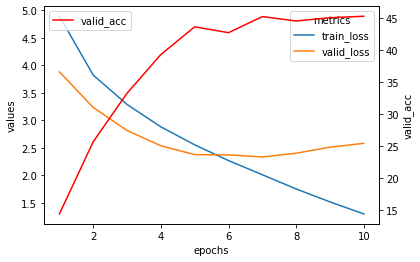

In [ ]:
plot_metrics(result_df)

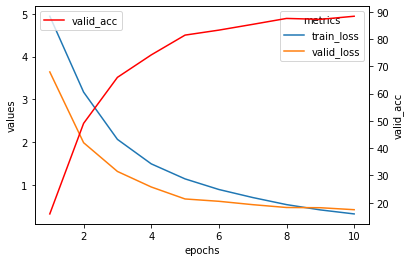

In [ ]:
plot_metrics(result_res_df)

# Data augmentation

In [ ]:
# All image is 224 X 224 X 3, no need resiez eand centercrop

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)
valid_data = datasets.ImageFolder(root=val_dir, transform=test_transform)

In [ ]:
# obtain training indices that will be used for validation
num_train, num_valid = len(train_data), len(valid_data)
train_index, valid_index = list(range(num_train)), list(range(num_valid))
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size,
                                          sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                         num_workers = num_workers)

In [ ]:
result_res_aug = train(10, len(classes), model_res, train_loader, valid_loader)

Epoch:  1

Valid Accuracy: 19%
Train Loss = 4.8934
Valid Loss = 3.3973
Training complete in 374m 32s
Epoch:  2

Valid Accuracy: 50%
Train Loss = 2.9852
Valid Loss = 1.9452
Training complete in 4m 22s
Epoch:  3

Valid Accuracy: 70%
Train Loss = 1.9251
Valid Loss = 1.1236
Training complete in 4m 23s
Epoch:  4

Valid Accuracy: 79%
Train Loss = 1.4225
Valid Loss = 0.7821
Training complete in 4m 23s
Epoch:  5

Valid Accuracy: 81%
Train Loss = 1.1214
Valid Loss = 0.7283
Training complete in 4m 27s
Epoch:  6

Valid Accuracy: 83%
Train Loss = 0.8999
Valid Loss = 0.5694
Training complete in 4m 25s
Epoch:  7

Valid Accuracy: 86%
Train Loss = 0.7374
Valid Loss = 0.4788
Training complete in 4m 23s
Epoch:  8

Valid Accuracy: 87%
Train Loss = 0.6084
Valid Loss = 0.4303
Training complete in 4m 21s
Epoch:  9

Valid Accuracy: 88%
Train Loss = 0.5151
Valid Loss = 0.4257
Training complete in 4m 22s
Epoch:  10

Valid Accuracy: 90%
Train Loss = 0.4241
Valid Loss = 0.3538
Training complete in 4m 20s


In [ ]:
test(classes, model_res, test_loader)

Test Accuracy of ABBOTTS BABBLER: 100% ( 5/ 5)
Test Accuracy of ABBOTTS BOOBY: 20% ( 1/ 5)
Test Accuracy of ABYSSINIAN GROUND HORNBILL: 100% ( 5/ 5)
Test Accuracy of AFRICAN CROWNED CRANE: 100% ( 5/ 5)
Test Accuracy of AFRICAN EMERALD CUCKOO: 80% ( 4/ 5)
Test Accuracy of AFRICAN FIREFINCH: 100% ( 5/ 5)
Test Accuracy of AFRICAN OYSTER CATCHER: 100% ( 5/ 5)
Test Accuracy of ALBATROSS: 80% ( 4/ 5)
Test Accuracy of ALBERTS TOWHEE: 100% ( 5/ 5)
Test Accuracy of ALEXANDRINE PARAKEET: 80% ( 4/ 5)
Test Accuracy of ALPINE CHOUGH: 80% ( 4/ 5)
Test Accuracy of ALTAMIRA YELLOWTHROAT: 80% ( 4/ 5)
Test Accuracy of AMERICAN AVOCET: 100% ( 5/ 5)
Test Accuracy of AMERICAN BITTERN: 100% ( 5/ 5)
Test Accuracy of AMERICAN COOT: 100% ( 5/ 5)
Test Accuracy of AMERICAN GOLDFINCH: 100% ( 5/ 5)
Test Accuracy of AMERICAN KESTREL: 100% ( 5/ 5)
Test Accuracy of AMERICAN PIPIT: 80% ( 4/ 5)
Test Accuracy of AMERICAN REDSTART: 80% ( 4/ 5)
Test Accuracy of AMETHYST WOODSTAR: 100% ( 5/ 5)
Test Accuracy of ANDEAN GOOSE

In [ ]:
result_res_aug_df = pd.DataFrame(result_res_aug, columns=['train_loss','valid_loss','valid_acc'])
result_res_aug_df.to_csv("/content/drive/MyDrive/NEU/DataMining/Project/result_res_aug_df.csv")

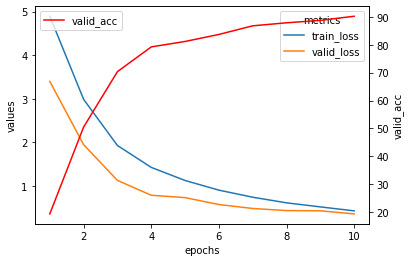

In [ ]:
plot_metrics(result_res_aug_df)

- ColorJitter

In [ ]:
# All image is 224 X 224 X 3, no need resiez eand centercrop

train_transform = transforms.Compose([
    transforms.ColorJitter(contrast=0.4, saturation=0.4, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)
valid_data = datasets.ImageFolder(root=val_dir, transform=test_transform)

In [ ]:
# obtain training indices that will be used for validation
num_train, num_valid = len(train_data), len(valid_data)
train_index, valid_index = list(range(num_train)), list(range(num_valid))
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size,
                                          sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                         num_workers = num_workers)

In [ ]:
result_res_aug2 = train(10, len(classes), model_res, train_loader, valid_loader)

Epoch:  1

Valid Accuracy:  6%
Train Loss = 5.4635
Valid Loss = 4.5577
Training complete in 412m 2s
Epoch:  2

Valid Accuracy: 33%
Train Loss = 4.0623
Valid Loss = 2.797
Training complete in 10m 15s
Epoch:  3

Valid Accuracy: 55%
Train Loss = 2.8014
Valid Loss = 1.7318
Training complete in 10m 27s
Epoch:  4

Valid Accuracy: 68%
Train Loss = 2.0559
Valid Loss = 1.2115
Training complete in 10m 24s
Epoch:  5

Valid Accuracy: 76%
Train Loss = 1.5837
Valid Loss = 0.9065
Training complete in 10m 1s
Epoch:  6

Valid Accuracy: 80%
Train Loss = 1.2429
Valid Loss = 0.7539
Training complete in 10m 44s
Epoch:  7

Valid Accuracy: 80%
Train Loss = 0.9897
Valid Loss = 0.7094
Training complete in 10m 44s
Epoch:  8

Valid Accuracy: 83%
Train Loss = 0.7844
Valid Loss = 0.5743
Training complete in 10m 15s
Epoch:  9

Valid Accuracy: 85%
Train Loss = 0.6124
Valid Loss = 0.5695
Training complete in 9m 57s
Epoch:  10

Valid Accuracy: 86%
Train Loss = 0.4755
Valid Loss = 0.5023
Training complete in 9m 57s


In [ ]:
test(classes, model_res, test_loader)

Test Accuracy of ABBOTTS BABBLER: 60% ( 3/ 5)
Test Accuracy of ABBOTTS BOOBY: 20% ( 1/ 5)
Test Accuracy of ABYSSINIAN GROUND HORNBILL: 100% ( 5/ 5)
Test Accuracy of AFRICAN CROWNED CRANE: 80% ( 4/ 5)
Test Accuracy of AFRICAN EMERALD CUCKOO: 60% ( 3/ 5)
Test Accuracy of AFRICAN FIREFINCH: 80% ( 4/ 5)
Test Accuracy of AFRICAN OYSTER CATCHER: 100% ( 5/ 5)
Test Accuracy of ALBATROSS: 60% ( 3/ 5)
Test Accuracy of ALBERTS TOWHEE: 100% ( 5/ 5)
Test Accuracy of ALEXANDRINE PARAKEET: 80% ( 4/ 5)
Test Accuracy of ALPINE CHOUGH: 60% ( 3/ 5)
Test Accuracy of ALTAMIRA YELLOWTHROAT: 60% ( 3/ 5)
Test Accuracy of AMERICAN AVOCET: 100% ( 5/ 5)
Test Accuracy of AMERICAN BITTERN: 100% ( 5/ 5)
Test Accuracy of AMERICAN COOT: 100% ( 5/ 5)
Test Accuracy of AMERICAN GOLDFINCH: 100% ( 5/ 5)
Test Accuracy of AMERICAN KESTREL: 60% ( 3/ 5)
Test Accuracy of AMERICAN PIPIT: 80% ( 4/ 5)
Test Accuracy of AMERICAN REDSTART: 80% ( 4/ 5)
Test Accuracy of AMETHYST WOODSTAR: 100% ( 5/ 5)
Test Accuracy of ANDEAN GOOSE: 80

In [ ]:
result_res_aug2_df = pd.DataFrame(result_res_aug2, columns=['train_loss','valid_loss','valid_acc'])
result_res_aug2_df.to_csv("/content/drive/MyDrive/NEU/DataMining/Project/result_res_aug2_df.csv")

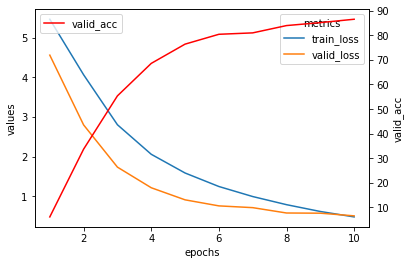

In [ ]:
plot_metrics(result_res_aug2_df)

- Combination

In [ ]:
# All image is 224 X 224 X 3, no need resiez eand centercrop

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(contrast=0.4, saturation=0.4, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)
valid_data = datasets.ImageFolder(root=val_dir, transform=test_transform)

In [ ]:
# obtain training indices that will be used for validation
num_train, num_valid = len(train_data), len(valid_data)
train_index, valid_index = list(range(num_train)), list(range(num_valid))
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                           sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size,
                                          sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                         num_workers = num_workers)

In [ ]:
result_res_aug3 = train(10, len(classes), model_res, train_loader, valid_loader)

Epoch:  1

Valid Accuracy:  4%
Train Loss = 5.5809
Valid Loss = 5.0319
Training complete in 385m 29s
Epoch:  2

Valid Accuracy: 31%
Train Loss = 4.2374
Valid Loss = 2.9956
Training complete in 9m 17s
Epoch:  3

Valid Accuracy: 54%
Train Loss = 2.9254
Valid Loss = 1.8193
Training complete in 9m 14s
Epoch:  4

Valid Accuracy: 68%
Train Loss = 2.1608
Valid Loss = 1.2617
Training complete in 9m 16s
Epoch:  5

Valid Accuracy: 72%
Train Loss = 1.6978
Valid Loss = 1.0867
Training complete in 9m 15s
Epoch:  6

Valid Accuracy: 79%
Train Loss = 1.3675
Valid Loss = 0.7659
Training complete in 9m 10s
Epoch:  7

Valid Accuracy: 82%
Train Loss = 1.121
Valid Loss = 0.6485
Training complete in 9m 11s
Epoch:  8

Valid Accuracy: 84%
Train Loss = 0.9396
Valid Loss = 0.5505
Training complete in 9m 14s
Epoch:  9

Valid Accuracy: 87%
Train Loss = 0.7821
Valid Loss = 0.4715
Training complete in 9m 15s
Epoch:  10

Valid Accuracy: 88%
Train Loss = 0.6617
Valid Loss = 0.4183
Training complete in 9m 16s


In [ ]:
test(classes, model_res, test_loader)

In [ ]:
result_res_aug3_df = pd.DataFrame(result_res_aug3, columns=['train_loss','valid_loss','valid_acc'])
result_res_aug3_df.to_csv("/content/drive/MyDrive/NEU/DataMining/Project/result_res_aug2_df.csv")

In [ ]:
plot_metrics(result_res_aug3_df)